<a href="https://colab.research.google.com/github/AchiniR/DM-group-project/blob/main/netflix_k_mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataset
#https://www.kaggle.com/datasets/jhajalaj/netflix-india-shows-and-movies/data


# Ref
#https://www.kaggle.com/code/bansodesandeep/netflix-movies-and-tv-shows-clustering/notebook#4.-Cleaning-data

In [2]:
!pip install kmodes
!pip install yellowbrick
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import contractions
import nltk
from nltk.corpus import stopwords
import string
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

In [4]:
# reading data
path = '/content/drive/MyDrive/DM_prroject/netflix_india_shows_and_movies.csv'

original_df = pd.read_csv(path,index_col='showid')
df = original_df.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6698 entries, 81607354 to 81023623
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                6698 non-null   object 
 1   type                6698 non-null   object 
 2   rating              6698 non-null   object 
 3   duration            6698 non-null   object 
 4   description         6698 non-null   object 
 5   hook_text           3165 non-null   object 
 6   genre               6698 non-null   object 
 7   release_year        6685 non-null   float64
 8   release_date        6698 non-null   object 
 9   mood_tag            6051 non-null   object 
 10  actors              6031 non-null   object 
 11  creator             1174 non-null   object 
 12  director            4260 non-null   object 
 13  audio               3998 non-null   object 
 14  subtitles           3997 non-null   object 
 15  tags                6698 non-null   object 


In [6]:
df.head()

name      type   rating  duration  \
showid                                                          
81607354        A Killer Paradox  TVSeries        A  1 Season   
81616617                   Ashes     Movie        A    1.6667   
81732726                Bhakshak     Movie        A      2.25   
81611991  Lover, Stalker, Killer     Movie  U/A 16+       1.5   
70305903            Interstellar     Movie  U/A 13+    2.8167   

                                                description hook_text  \
showid                                                                  
81607354  When one accidental killing leads to another, ...       NaN   
81616617  From an intoxicating fantasy to a dangerous af...       NaN   
81732726  A struggling local journalist begins a dogged ...       NaN   
81611991  In this twisting documentary, a mechanic tries...       NaN   
70305903  With humanity teetering on the brink of extinc...       NaN   

                genre  release_year release_date  \
showid                                             
81607354     Thriller        2024.0     2024-2-9   
81616617        Drama        2024.0     2024-2-9   
81732726        Drama        2024.0     2024-2-9   
81611991  Documentary        2024.0     2024-2-9   
70305903       Sci-Fi        2014.0     2024-2-9   

                                 mood_tag  \
showid                                      
81607354              Offbeat;Suspenseful   
81616617  Psychological;Intimate;Romantic   
81732726                           Gritty   
81611991                              NaN   
70305903            Mind-Bending;Cerebral   

                                                     actors  \
showid                                                        
81607354               Choi Woo-shik;Son Suk-ku;Lee Hee-jun   
81616617  Funda Eryiğit;Alperen Duymaz;Mehmet Günsür;Nur...   
81732726  Bhumi Pednekar;Sanjay Mishra;Aditya Srivastava...   
81611991                                                NaN   
70305903  Matthew McConaughey;Anne Hathaway;Jessica Chas...   

                           creator           director  \
showid                                                  
81607354  Lee Chang-hee;Kim Da-min                NaN   
81616617                       NaN      Erdem Tepegöz   
81732726                       NaN             Pulkit   
81611991                       NaN      Sam Hobkinson   
70305903                       NaN  Christopher Nolan   

                                                      audio  \
showid                                                        
81607354                                                NaN   
81616617  English;Turkish - Audio Description;Turkish [O...   
81732726  English;Hindi - Audio Description;Hindi [Origi...   
81611991     English - Audio Description;English [Original]   
70305903                                 English [Original]   

                        subtitles  \
showid                              
81607354                      NaN   
81616617  English;English;Turkish   
81732726    English;English;Hindi   
81611991                  English   
70305903            English;Hindi   

                                                       tags  \
showid                                                        
81607354  Korean;Crime TV Shows;K-dramas based on Webtoo...   
81616617                     Turkish;Dramas;Romantic Movies   
81732726  Hindi-Language Movies;Bollywood Movies;Crime M...   
81611991  Documentaries;Crime Movies;True Crime Document...   
70305903  Sci-Fi Movies;Dramas;Action & Adventure Movies...   

                                          similar_titles_id production_country  
showid                                                                          
81607354  81444051;81461539;81011211;81640988;80990668;8...        South Korea  
81616617  81732726;81256740;81671215;81637260;81566662;8...             Turkey  
81732726  81671215;81637260;81725616;81637261;81740214;8...          

In [7]:
# calculating missing values
missing_values = df.isnull()
total_missing_values = missing_values.sum()
print(total_missing_values)

name                     0
type                     0
rating                   0
duration                 0
description              0
hook_text             3533
genre                    0
release_year            13
release_date             0
mood_tag               647
actors                 667
creator               5524
director              2438
audio                 2700
subtitles             2701
tags                     0
similar_titles_id       11
production_country     554
dtype: int64


In [8]:
# convert to date-time
df["release_date"] = pd.to_datetime(df['release_date'])

# create seperate column for year, month, and day
df['month'] = df['release_date'].dt.month.astype(str)
df['year'] = df['release_date'].dt.year.astype(str)
df['day'] = df['release_date'].dt.day.astype(str)

df['day_of_week'] = df['release_date'].dt.dayofweek
df['weekend'] = df['day_of_week'].isin([5, 6]).astype(str)

In [9]:
#Drop columns
df.drop('release_year',axis=1,inplace=True)
df.drop('creator',axis=1,inplace=True)
df.drop('release_date',axis=1,inplace=True)

In [10]:
df[['director','actors','production_country', 'hook_text', 'audio', 'subtitles', 'mood_tag']] = df[['director','actors','production_country', 'hook_text', 'audio', 'subtitles', 'mood_tag']].fillna('Unknown')
df[['similar_titles_id']] = df[['similar_titles_id']].fillna('None')
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])

In [11]:
df[df['year']==1970]

Empty DataFrame
Columns: [name, type, rating, duration, description, hook_text, genre, mood_tag, actors, director, audio, subtitles, tags, similar_titles_id, production_country, month, year, day, day_of_week, weekend]
Index: []

In [12]:
## droping the 1970 movies as all the other movies are from 2015 to present
df.drop(df[df['year']==1970].index, axis=0,inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6698 entries, 81607354 to 81023623
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   name                6698 non-null   object
 1   type                6698 non-null   object
 2   rating              6698 non-null   object
 3   duration            6698 non-null   object
 4   description         6698 non-null   object
 5   hook_text           6698 non-null   object
 6   genre               6698 non-null   object
 7   mood_tag            6698 non-null   object
 8   actors              6698 non-null   object
 9   director            6698 non-null   object
 10  audio               6698 non-null   object
 11  subtitles           6698 non-null   object
 12  tags                6698 non-null   object
 13  similar_titles_id   6698 non-null   object
 14  production_country  6698 non-null   object
 15  month               6698 non-null   object
 16  year         

In [109]:
selected_columns = ['rating', 'genre', 'mood_tag','description','tags', 'production_country','month','year','weekend', ]
# selected_columns = ['description' ]

# Create a new DataFrame with only the selected columns
df_trans = df[selected_columns].copy()

In [117]:
df_trans.head()

rating        genre                         mood_tag  \
showid                                                            
81607354        A     Thriller              Offbeat;Suspenseful   
81616617        A        Drama  Psychological;Intimate;Romantic   
81732726        A        Drama                           Gritty   
81611991  U/A 16+  Documentary                          Unknown   
70305903  U/A 13+       Sci-Fi            Mind-Bending;Cerebral   

                                                description  \
showid                                                        
81607354  When one accidental killing leads to another, ...   
81616617  From an intoxicating fantasy to a dangerous af...   
81732726  A struggling local journalist begins a dogged ...   
81611991  In this twisting documentary, a mechanic tries...   
70305903  With humanity teetering on the brink of extinc...   

                                                       tags  \
showid                                                        
81607354  Korean;Crime TV Shows;K-dramas based on Webtoo...   
81616617                     Turkish;Dramas;Romantic Movies   
81732726  Hindi-Language Movies;Bollywood Movies;Crime M...   
81611991  Documentaries;Crime Movies;True Crime Document...   
70305903  Sci-Fi Movies;Dramas;Action & Adventure Movies...   

         production_country month  year weekend  
showid                                           
81607354        South Korea     2  2024   False  
81616617             Turkey     2  2024   False  
81732726              India     2  2024   False  
81611991            Unknown     2  2024   False  
70305903      United States     2  2024   False

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1528, cost: 42523.0
Run 1, iteration: 2/100, moves: 0, cost: 42523.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 135, cost: 43434.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1735, cost: 42259.0
Run 3, iteration: 2/100, moves: 133, cost: 42259.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 429, cost: 43551.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1813, cost: 42460.0
Run 5, iteration: 2/100, moves: 10, cost: 42460.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 1351, cost: 42378.0
Init: initializing centroids
Init: initializing clusters
Sta

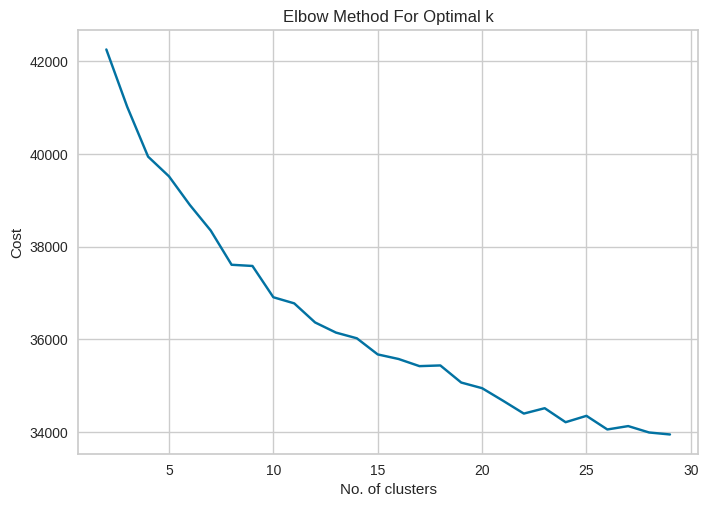

In [118]:
# Elbow curve to find optimal K
cost = []
K = range(2,30)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 10, verbose=1)
    kmode.fit_predict(df_trans)
    cost.append(kmode.cost_)

plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [119]:
# Building the model with 22 clusters
kmode = KModes(n_clusters=22, init = "random", n_init = 10, verbose=1)
clusters = kmode.fit_predict(df_trans)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2217, cost: 34842.0
Run 1, iteration: 2/100, moves: 713, cost: 34638.0
Run 1, iteration: 3/100, moves: 86, cost: 34638.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1830, cost: 35152.0
Run 2, iteration: 2/100, moves: 39, cost: 35152.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1855, cost: 35032.0
Run 3, iteration: 2/100, moves: 222, cost: 35032.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1728, cost: 34949.0
Run 4, iteration: 2/100, moves: 386, cost: 34919.0
Run 4, iteration: 3/100, moves: 6, cost: 34919.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1869, cost: 34957.0
Run 5, iteration: 2/100, moves: 147, c

In [18]:
def calculate_dissimilarity(sample1, sample2):
    """
    Calculate dissimilarity between two samples based on the given metric.

    Args:
    - sample1: list or array-like, representing the features of sample 1
    - sample2: list or array-like, representing the features of sample 2

    Returns:
    - dissimilarity: float, dissimilarity between the two samples
    """
    p = len(set(sample1))  # Number of unique classes/categories
    m = sum(1 for x, y in zip(sample1, sample2) if x == y)  # Number of matches
    dissimilarity = (p - m) / p
    return dissimilarity

def calculate_average_dissimilarity(cluster):
    """
    Calculate the average dissimilarity within a cluster.

    Args:
    - cluster: list of lists or 2D array, representing the samples in the cluster

    Returns:
    - avg_dissimilarity: float, average dissimilarity within the cluster
    """
    n_samples = len(cluster)
    total_dissimilarity = 0

    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            total_dissimilarity += calculate_dissimilarity(cluster[i], cluster[j])

    avg_dissimilarity = total_dissimilarity / (n_samples * (n_samples - 1) / 2)
    return avg_dissimilarity

In [120]:
df_trans.insert(0, "Cluster", clusters, True)
df_trans

Cluster   rating        genre                         mood_tag  \
showid                                                                     
81607354        9        A     Thriller              Offbeat;Suspenseful   
81616617        9        A        Drama  Psychological;Intimate;Romantic   
81732726        9        A        Drama                           Gritty   
81611991        0  U/A 16+  Documentary                          Unknown   
70305903        9  U/A 13+       Sci-Fi            Mind-Bending;Cerebral   
...           ...      ...          ...                              ...   
80058424        8  U/A 16+       Comedy                            Witty   
80151644       12   U/A 7+         Kids                            Goofy   
80196044        3        A     Thriller                           Gritty   
81031181        3        A        Drama                          Unknown   
81023623        3        A        Drama                           Gritty   

                                                description  \
showid                                                        
81607354  When one accidental killing leads to another, ...   
81616617  From an intoxicating fantasy to a dangerous af...   
81732726  A struggling local journalist begins a dogged ...   
81611991  In this twisting documentary, a mechanic tries...   
70305903  With humanity teetering on the brink of extinc...   
...                                                     ...   
80058424  Armed with boyish charm and a sharp wit, the f...   
80151644  Puss in Boots has fallen into a magic book rul...   
80196044  After an unexpected misstep, a crew of skilled...   
81031181  Brash ladies' man Gregorio "Goyo" del Pilar ri...   
81023623  After an ambush leaves his partner dead, drug ...   

                                                       tags  \
showid                                                        
81607354  Korean;Crime TV Shows;K-dramas based on Webtoo...   
81616617                     Turkish;Dramas;Romantic Movies   
81732726  Hindi-Language Movies;Bollywood Movies;Crime M...   
81611991  Documentaries;Crime Movies;True Crime Document...   
70305903  Sci-Fi Movies;Dramas;Action & Adventure Movies...   
...                                                     ...   
80058424                                    Stand-Up Comedy   
80151644  Kids' TV;Children & Family Movies;Comedy Movie...   
80196044      French;Crime Movies;Action & Adventure Movies   
81031181  Filipino;Military Movies;Dramas;Period Pieces;...   
81023623                         French;Crime Movies;Dramas   

         production_country month  year weekend  
showid                                           
81607354        South Korea     2  2024   False  
81616617             Turkey     2  2024   False  
81732726              India     2  2024   False  
81611991            Unknown     2  2024   False  
70305903      United States     2  2024   False  
...                     ...   ...   ...     ...  
80058424            Unknown    11  2015   False  
80151644      United States     1  1970   False  
80196044             France     1  1970   False  
81031181        Philippines     1  1970   False  
81023623             France     1  1970   False  

[6698 rows x 10 columns]

In [20]:
#group the dataframe with clusters
# grouped_df = df_trans.groupby('Cluster')

# # Print the groups
# for group, group_df in grouped_df:
#     print(f"Group: {group}")
#     avg_dissimilarity = calculate_average_dissimilarity(group_df)
#     print(f"Average dissimilarity within the cluster {group}:", avg_dissimilarity)

In [21]:
#word cloud imports
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [126]:
df_wordcloud = df_trans[['Cluster','description']].dropna()
df_wordcloud

Cluster                                        description
showid                                                              
81607354        9  When one accidental killing leads to another, ...
81616617        9  From an intoxicating fantasy to a dangerous af...
81732726        9  A struggling local journalist begins a dogged ...
81611991        0  In this twisting documentary, a mechanic tries...
70305903        9  With humanity teetering on the brink of extinc...
...           ...                                                ...
80058424        8  Armed with boyish charm and a sharp wit, the f...
80151644       12  Puss in Boots has fallen into a magic book rul...
80196044        3  After an unexpected misstep, a crew of skilled...
81031181        3  Brash ladies' man Gregorio "Goyo" del Pilar ri...
81023623        3  After an ambush leaves his partner dead, drug ...

[6698 rows x 2 columns]

cluster 0


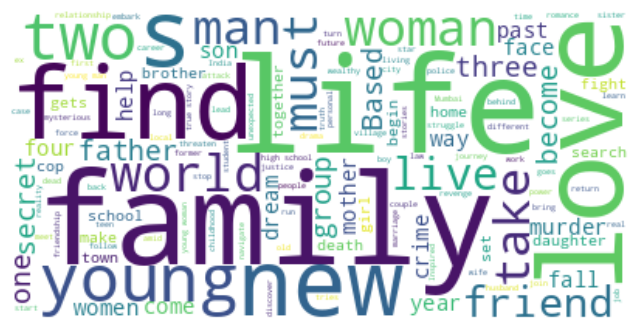

cluster 1


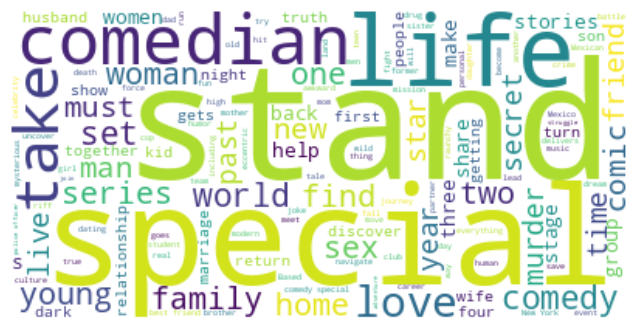

cluster 2


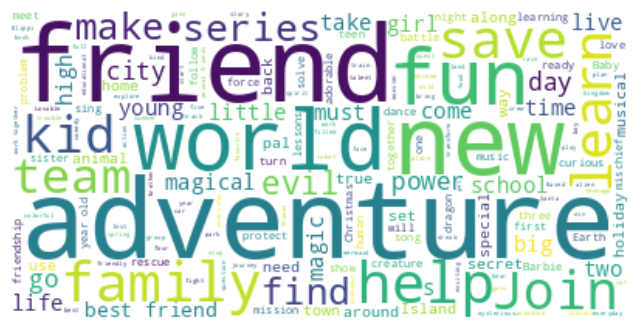

cluster 3


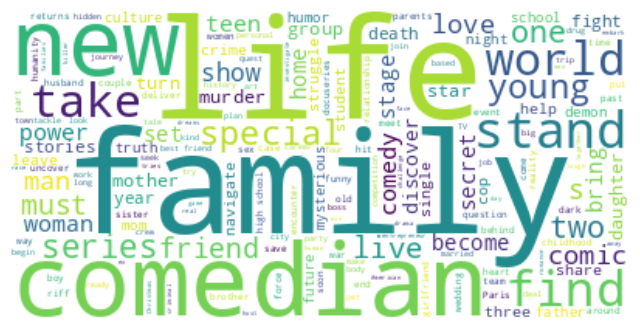

cluster 4


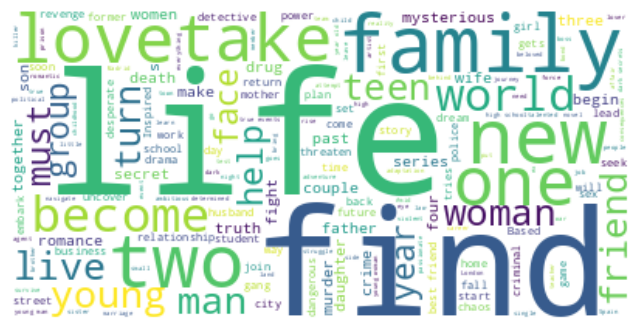

cluster 5


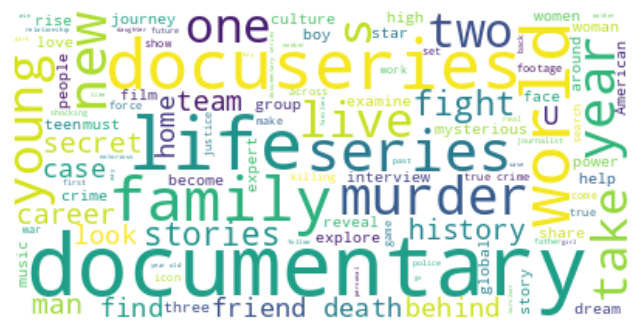

cluster 6


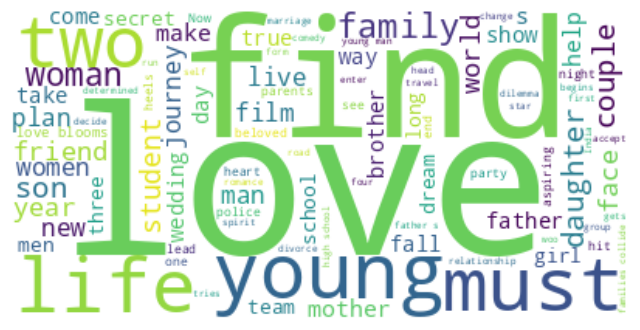

cluster 7


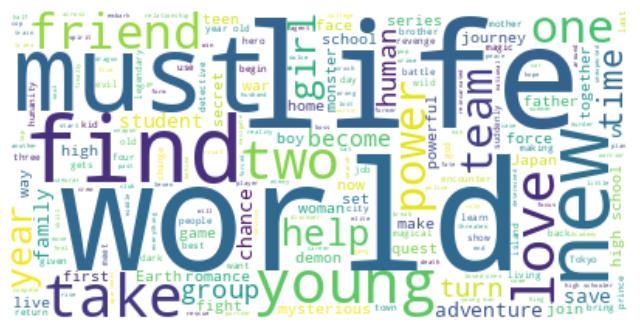

cluster 8


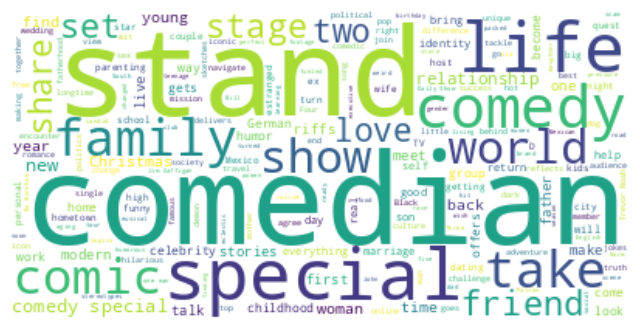

cluster 9


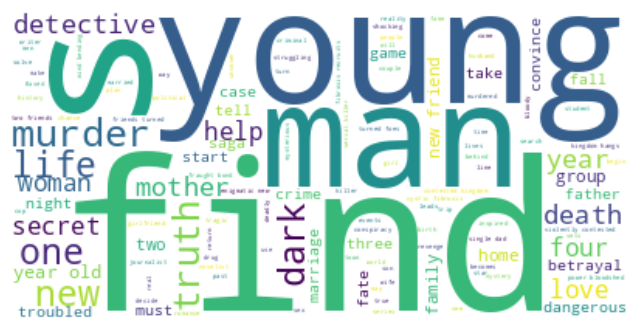

cluster 10


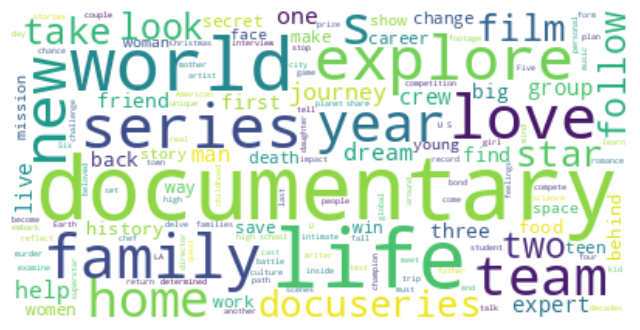

cluster 11


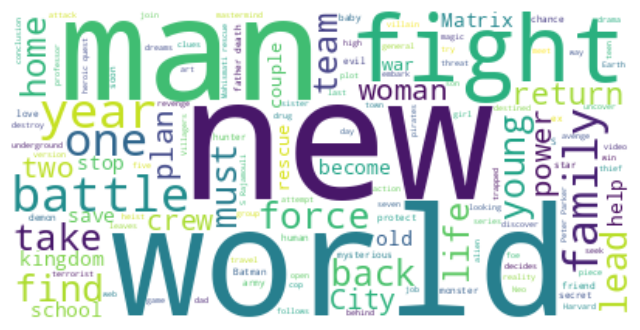

cluster 12


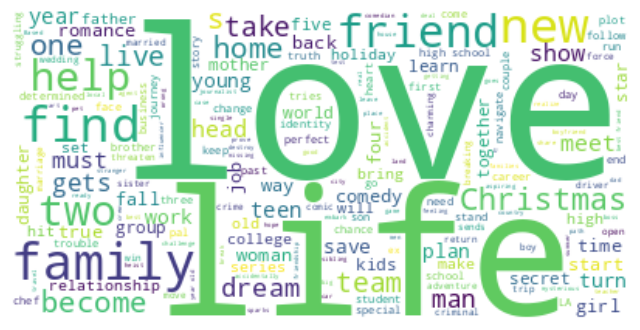

cluster 13


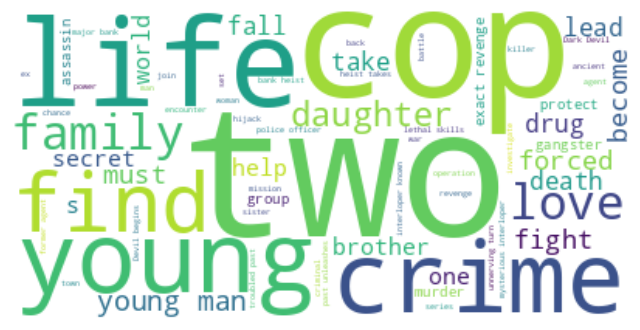

cluster 14


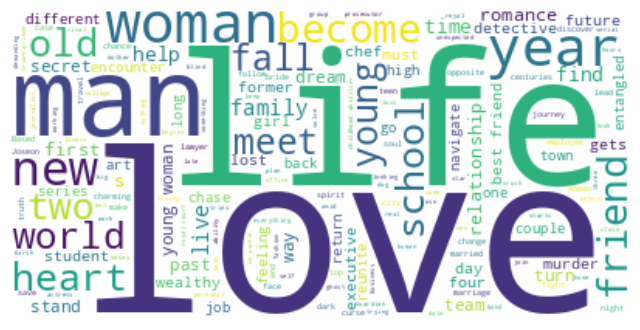

cluster 15


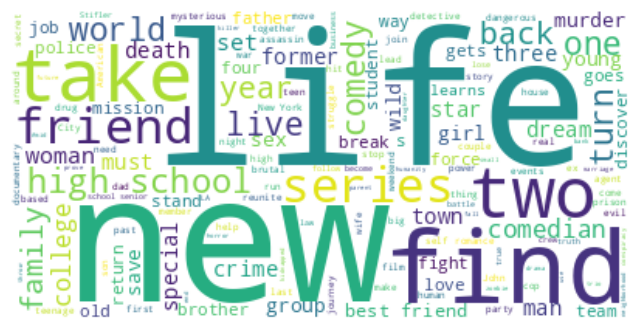

In [125]:
def kmode_worldcloud(cluster_number, column_name):


  netflix_df_wordcloud = df_trans[['Cluster',column_name]].dropna()
  netflix_df_wordcloud = netflix_df_wordcloud[df_trans['Cluster']==cluster_number]

  # text documents
  text = " ".join(word for word in netflix_df_wordcloud[column_name])

  # create the word cloud
  wordcloud = WordCloud(stopwords=set(STOPWORDS), background_color="white").generate(text)

  # Generate a word cloud image
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


for i in range(16):
  print(f'cluster {i}')
  kmode_worldcloud(i,'description')

# Model evaluation

In [121]:
np.unique(clusters)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=uint16)

In [122]:
df_eval = df_trans.copy()

df_eval['year'] = df_eval['year'].astype(int)
df_eval['month'] = df_eval['month'].astype(int)

label_encoder = LabelEncoder()

# Fit and transform the 'rating' column
df_eval['weekend'] = label_encoder.fit_transform(df_eval['weekend'])
df_eval["rating"] = label_encoder.fit_transform(df_eval["rating"])
df_eval["genre"] = label_encoder.fit_transform(df_eval["genre"])
# Extract numerical part from 'duration' column
# df_eval['duration'] = df_eval['duration'].str.extract('(\d+\.?\d*)').astype(float)
df_eval = pd.get_dummies(df_eval, columns=['production_country'])

#dropping unknown tags column
df_eval.drop('production_country_Unknown',axis=1,inplace=True)

In [123]:
# Split tags with multiple values
tags_split = [tag.split(';') for tag in df_eval['mood_tag'].values]

# Use MultiLabelBinarizer for one-hot encoding
mlb = MultiLabelBinarizer()
encoded_tags = pd.DataFrame(mlb.fit_transform(tags_split), columns=mlb.classes_)
#dropping unknown tags column
encoded_tags.drop('Unknown',axis=1,inplace=True)
encoded_tags['showid'] = df_eval.index
tags_final = encoded_tags.set_index('showid')
df_eval = pd.merge(df_eval, tags_final, left_index=True, right_index=True)
# dropping other columns
df_eval.drop([ 'description', 'tags', 'mood_tag', ],axis=1,inplace=True)

In [124]:
# Calculate evaluation metrics
print('~~'*45)
print('Evaluation result :\n')
silhouette = silhouette_score(df_eval, clusters)
ch_score = calinski_harabasz_score(df_eval, clusters)
db_score = davies_bouldin_score(df_eval, clusters)

# Print the results
print(f"Number of clusters: {len(set(clusters))}")
print(f"Silhouette score: {silhouette}")
print(f"Calinski-Harabasz score: {ch_score}")
print(f"Davies-Bouldin score: {db_score}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Evaluation result :

Number of clusters: 22
Silhouette score: 0.012406892604634573
Calinski-Harabasz score: 445.3892146350614
Davies-Bouldin score: 3.7887112307768693


+----+-------------------------+-------------+
|    | Evaluation Metrics      |      Result |
+====+=========================+=============+
|  0 | Silhouette score        |   0.0124069 |
+----+-------------------------+-------------+
|  1 | Calinski-Harabasz score | 445.389     |
+----+-------------------------+-------------+
|  2 | Davies-Bouldin score    |   3.78871   |
+----+-------------------------+-------------+

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



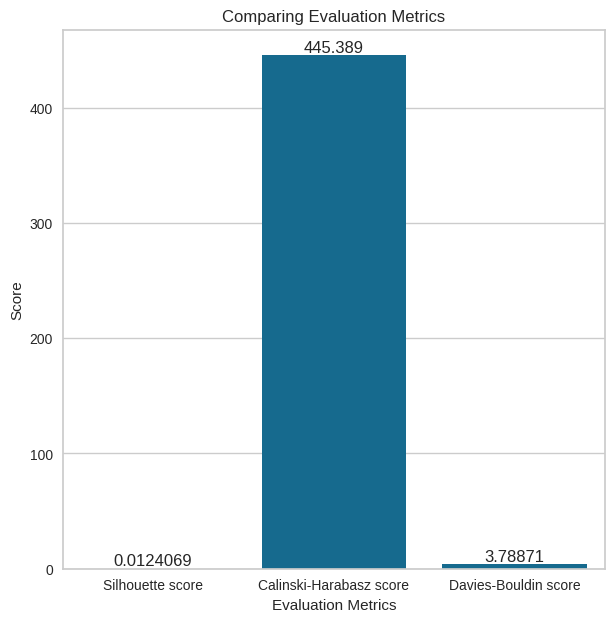

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [127]:
metrics = ['Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score']
ev_result = [silhouette, ch_score, db_score]

# Create a dataframe
evaluation_df = pd.DataFrame({'Evaluation Metrics': metrics,
                'Result': ev_result})
# Print dataframe
print(tabulate(evaluation_df, headers='keys', tablefmt='grid'))
print('\n', '~~'*45, '\n')

plt.figure(figsize=(7,7))
ax=sns.barplot(x=evaluation_df['Evaluation Metrics'], y=evaluation_df['Result'])
ax.bar_label(ax.containers[0])
ax.set_title("Comparing Evaluation Metrics")
ax.set_xlabel("Evaluation Metrics")
ax.set_ylabel("Score")
ax.legend(loc="best")

# Show the plot
plt.show()
print('~~'*45)

# Recommendation System

In [28]:
df_test = df_trans.drop('Cluster',axis=1)

In [29]:
cluster_centroids = pd.DataFrame(kmode.cluster_centroids_, columns=df_test.columns)

cluster_centroids


name   rating        genre          mood_tag  \
0            Cowboy Bebop        A        Anime          Exciting   
1                  #Alive  U/A 16+        Drama           Unknown   
2             Johnny Test   U/A 7+         Kids           Unknown   
3           Mortal Kombat  U/A 13+       Comedy           Unknown   
4               15 August  U/A 16+       Comedy             Witty   
5                   Noise  U/A 16+        Drama           Unknown   
6              Collateral        A        Drama           Unknown   
7                    1983        A     Thriller  Dark;Suspenseful   
8                   Black  U/A 13+        Drama           Unknown   
9                    13TH  U/A 13+  Documentary     Investigative   
10               (Un)Well  U/A 13+  Documentary     Investigative   
11                     4L        A       Comedy           Raunchy   
12               Wild Dog  U/A 16+        Drama          Exciting   
13  A Breath of Fresh Air  U/A 13+       Comedy             Goofy   
14    #FriendButMarried 2  U/A 13+        Drama         Emotional   
15                   1922        A       Horror             Scary   

                                          description  \
0   A police officer with a tendency to take justi...   
1   A jaded former intelligence agent is pulled ba...   
2   "King of Bollywood" Shah Rukh Khan opens up ab...   
3   This thriller traces a now-infamous fugitive's...   
4   While honoring their ancestors, a family awake...   
5   When a private school teacher is assigned to a...   
6   Amid the daily grind in a coal mining town, po...   
7   A Chinese pharmaceutical lawyer framed for a v...   
8   A 6-year-old with cystic fibrosis recruits the...   
9   "Everybody Loves Raymond" creator Phil Rosenth...   
10  24 female police officers, firefighters, bodyg...   
11  After growing up enduring criticism from his f...   
12  A major bank heist takes an unnerving turn whe...   
13  A clumsy sleuth who dreams of joining the poli...   
14  An aspiring musician battles age-old caste div...   
15  As a series of murders hit close to home, a vi...   

                                               actors  \
0                                             Unknown   
1                                             Unknown   
2                                             Unknown   
3                                             Unknown   
4                                             Unknown   
5                                             Unknown   
6                                             Unknown   
7                                             Unknown   
8                                             Unknown   
9                                             Unknown   
10                                            Unknown   
11                                      Jim Jefferies   
12                                            Unknown   
13                                   Gabriel Iglesias   
14  Toru Furuya;Shuichi Ikeda;Hirotaka Suzuoki;Rum...   
15                                            Unknown   

                                                 tags production_country  \
0   Shounen Anime;Sci-Fi & Fantasy Anime;Action An...              Japan   
1                 Romantic TV Dramas;TV Dramas;Korean        South Korea   
2                                Kids' TV;TV Cartoons      United States   
3                                     Stand-Up Comedy      United States   
4                                     Stand-Up Comedy            Unknown   
5    Crime Movies;Action & Adventure Movies;US Movies      United States   
6   Dramas;Romantic Movies;Movies Based on Books;U...      United States   
7                             British;Stand-Up Comedy     United Kingdom   
8   Hindi-Language Movies;Bollywood Movies;Dramas;...              India   
9      Documentaries;Social & Cultural Docs;US Movies      United States   
10            Korean;TV Comedies;Romantic TV Comedies      United State

## convert cluster centroids and df to numerical

In [30]:
df_rec = original_df.drop(df[df['year']==1970].index, axis=0)

In [31]:
cluster_centroids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   name                16 non-null     object
 1   rating              16 non-null     object
 2   genre               16 non-null     object
 3   mood_tag            16 non-null     object
 4   description         16 non-null     object
 5   actors              16 non-null     object
 6   tags                16 non-null     object
 7   production_country  16 non-null     object
 8   month               16 non-null     object
 9   year                16 non-null     object
 10  weekend             16 non-null     object
 11  duration            16 non-null     object
dtypes: object(12)
memory usage: 1.6+ KB


In [32]:
cluster_centroids['year'] = cluster_centroids['year'].astype(int)
cluster_centroids['month'] = cluster_centroids['month'].astype(int)

label_encoder = LabelEncoder()

# Fit and transform the 'rating' column
cluster_centroids['weekend'] = label_encoder.fit_transform(cluster_centroids['weekend'])
cluster_centroids["rating"] = label_encoder.fit_transform(cluster_centroids["rating"])
cluster_centroids["genre"] = label_encoder.fit_transform(cluster_centroids["genre"])
# Extract numerical part from 'duration' column
cluster_centroids['duration'] = cluster_centroids['duration'].str.extract('(\d+\.?\d*)').astype(float)
cluster_centroids = pd.get_dummies(cluster_centroids, columns=['mood_tag'])
cluster_centroids = pd.get_dummies(cluster_centroids, columns=['production_country'])

#dropping unknown tags column
cluster_centroids.drop('mood_tag_Unknown',axis=1,inplace=True)
cluster_centroids.drop('production_country_Unknown',axis=1,inplace=True)

#dropping other columns
cluster_centroids.drop(['name', 'description', 'actors','tags'],axis=1,inplace=True)